In [1]:
# !pip install -U segmentation-models-pytorch

In [2]:
# To fix module 'albumentations' has no attribute 'Lambda'
# !pip install -U git+https://github.com/albu/albumentations --no-cache-dir

In [3]:
# !pip install -U albumentations[imgaug]

## Loading data

For this example we will use **CamVid** dataset. It is a set of:
 - **train** images + segmentation masks
 - **validation** images + segmentation masks
 - **test** images + segmentation masks
 
All images have 320 pixels height and 480 pixels width.
For more inforamtion about dataset visit http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/.

In [1]:
# !nvidia-smi
print('hi')

hi


In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Set GPU-0 to use
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

### Dataloader

Writing helper class for data extraction, tranformation and preprocessing  
https://pytorch.org/docs/stable/data

In [4]:
# !git clone https://github.com/GeorgeSeif/Semantic-Segmentation-Suite.git

In [5]:
import os
from pathlib import Path

DATA_DIR = Path('Semantic-Segmentation-Suite/CamVid')

In [6]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_labels')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'val_labels')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_labels')

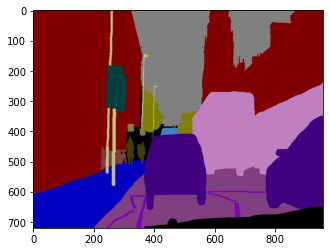

In [7]:
import numpy as np

mask = cv2.imread(str(DATA_DIR) + '/train_labels/0001TP_006690_L.png')
mask = cv2.cvtColor((mask).astype(np.uint8), cv2.COLOR_BGR2RGB)

plt.imshow(mask)

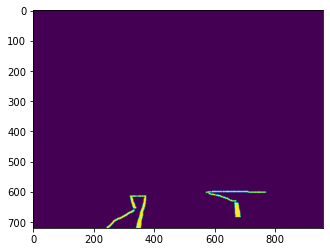

In [8]:
final = np.zeros((720, 960))
final[np.where((mask == [128, 0, 192]).all(axis=2))] = 1

plt.imshow(final)

In [9]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [10]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.mask_ids = []

        for name in self.ids:
          label_name = name[:-4] + "_L.png"
          self.mask_ids.append(label_name)


        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.mask_ids]

        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(self.masks_fps[i])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

        # Test
        #mask = np.where(mask==[128, 0, 192], 1, mask)
        # lower = np.array([280, 100, 75], dtype = "uint8")

        # hsv = cv2.cvtColor(mask, cv2.COLOR_BGR2HSV)
        # green_mask = cv2.inRange(hsv, lower, lower)
        # mask = cv2.bitwise_and(hsv,hsv,mask=green_mask)
        # mask = np.expand_dims(mask, axis=2)
        # Test end

        gt = np.zeros((len(image), len(image[0])))
        gt[np.where((mask == [128, 0, 192]).all(axis=2))] = 1

        # 384 480
        image = cv2.resize(image, (480, 384))
        mask = cv2.resize(gt, (480, 384))
        mask = np.expand_dims(mask, axis=2)

        #print(mask.shape)

        # apply augmentations
        if self.augmentation:
            #print('Augmentation')
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            #print(image.shape, mask.shape)
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

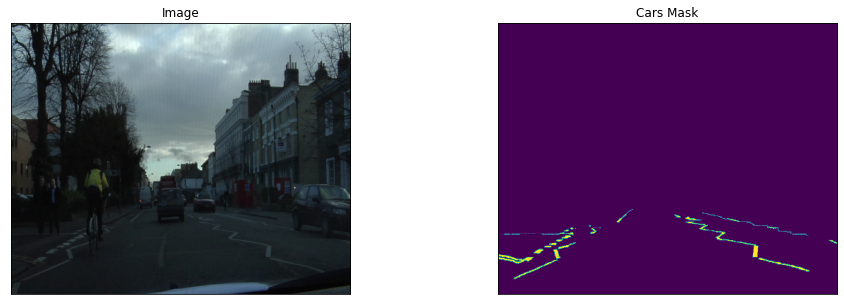

0.23636627197265625


In [11]:
import time

start_time = time.time()

# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir)
image, mask = dataset[15] # get some sample

visualize(
    image=image, 
    cars_mask=mask.squeeze(),
)

print(time.time() - start_time)

### Augmentations

In [12]:
import albumentations as albu

In [13]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.0001, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

320 320 3


C:\Users\Sergey Ivanov\AppData\Roaming\Python\Python38\site-packages\albumentations\imgaug\transforms.py:252: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
C:\Users\Sergey Ivanov\AppData\Roaming\Python\Python38\site-packages\albumentations\imgaug\transforms.py:375: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
C:\Users\Sergey Ivanov\AppData\Roaming\Python\Python38\site-packages\albumentations\augmentations\transforms.py:1800: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
C:\Users\Sergey Ivanov\AppData\Roaming\Python\Python38\site-packages\albumentations\imgaug\transforms.py:222: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.war

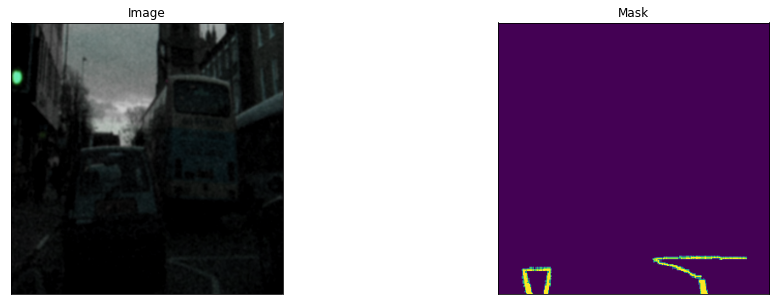

In [14]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(),
)

# same image with different random transforms
for i in range(1):
    image, mask = augmented_dataset[i]
    print(len(image), len(image[0]), len(image[0][0]))
    visualize(image=image, mask=mask.squeeze(-1))

test:
384 480 3
384 480 1


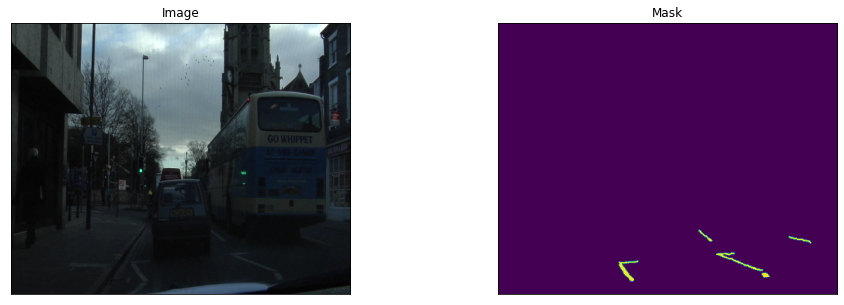

In [15]:
augmented_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation()
)

# same image with different random transforms
for i in range(1):
    image, mask = augmented_dataset[i]
    print("test:")
    print(len(image), len(image[0]), len(image[0][0]))
    print(len(mask), len(mask[0]), len(mask[0][0]))
    visualize(image=image, mask=mask.squeeze(-1))

## Create model and train

In [62]:
import wandb


wandb.init(
    project='lane_segmentation',
    entity='techtoker',
    config={
        "ENCODER": "se_resnext50_32x4d",
        'ENCODER_WEIGHTS': 'imagenet',
        "epoch": 30,
        "batch_size": 16,
        "lr":1e-4,
        "iou_threshold":0.5,
    })

config = wandb.config

dice_loss,███▇▇▇▆▆▆▅▅▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
iou_score,▁▂▃▃▄▅▄▅▆▆▇▇▇██▇██▇███████████
dice_loss,0.2597
iou_score,0.63254


In [63]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [64]:
ENCODER = config['ENCODER']
ENCODER_WEIGHTS = config['ENCODER_WEIGHTS']

CLASSES = ['car']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1, 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [65]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
)

train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'], shuffle=True)

In [66]:
# Get one sample from dataset; Check its size

inputs, classes = next(iter(train_loader))
print(f'Train: {inputs.size()}, {classes.size()}')

inputs, classes = next(iter(valid_loader))
print(f'Validation: {inputs.size()}, {classes.size()}')

Train: torch.Size([16, 3, 320, 320]), torch.Size([16, 1, 320, 320])
Validation: torch.Size([16, 3, 384, 480]), torch.Size([16, 1, 384, 480])


In [67]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=config['iou_threshold']),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=config['lr']),
])

In [68]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [69]:
# Free cuda memory

for i, left in enumerate(train_loader):
    print(i)
    with torch.no_grad():
        temp = model(left).view(-1, 1, 300, 300)
    right.append(temp.to('cpu'))
    del temp
    torch.cuda.empty_cache()

0


TypeError: conv2d() received an invalid combination of arguments - got (list, Parameter, NoneType, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: ([31;1mlist[0m, [31;1mParameter[0m, [31;1mNoneType[0m, [31;1mtuple[0m, [31;1mtuple[0m, [31;1mtuple[0m, [32;1mint[0m)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: ([31;1mlist[0m, [31;1mParameter[0m, [31;1mNoneType[0m, [31;1mtuple[0m, [31;1mtuple[0m, [31;1mtuple[0m, [32;1mint[0m)


In [ ]:
# train model for 40 epochs

max_score = 0

for i in range(0, config['epoch']):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    wandb.log({"train_iou_score": train_logs['iou_score'],
               "train_dice_loss": train_logs['dice_loss'],
               "valid_iou_score": valid_logs['iou_score'],
               "valid_dice_loss": valid_logs['dice_loss'] })
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
#     if i == 25:
#         optimizer.param_groups[0]['lr'] = 1e-5
#         print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|█████████████████████████████████████| 7/7 [00:06<00:00,  1.02it/s, dice_loss - 0.937, iou_score - 0.04037]
Model saved!

Epoch: 1
valid: 100%|████████████████████████████████████| 7/7 [00:06<00:00,  1.01it/s, dice_loss - 0.9186, iou_score - 0.08867]
Model saved!

Epoch: 2
valid: 100%|█████████████████████████████████████| 7/7 [00:07<00:00,  1.02s/it, dice_loss - 0.9019, iou_score - 0.1578]
Model saved!

Epoch: 3
valid: 100%|█████████████████████████████████████| 7/7 [00:07<00:00,  1.00s/it, dice_loss - 0.8923, iou_score - 0.2109]
Model saved!

Epoch: 4
valid: 100%|█████████████████████████████████████| 7/7 [00:06<00:00,  1.03it/s, dice_loss - 0.8787, iou_score - 0.2952]
Model saved!

Epoch: 5
valid: 100%|█████████████████████████████████████| 7/7 [00:06<00:00,  1.02it/s, dice_loss - 0.8608, iou_score - 0.3069]
Model saved!

Epoch: 6
valid: 100%|█████████████████████████████████████| 7/7 [00:06<00:00,  1.03it/s, dice_loss - 0.8383, iou_score - 0.3231]
Model saved!

## Test best saved model

In [ ]:
# load best saved checkpoint
best_model = torch.load('./best_model.pth')

In [ ]:
# create test dataset
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [ ]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 168/168 [00:29<00:00,  5.61it/s, dice_loss - 0.2769, iou_score - 0.6143]


## Visualize predictions

In [ ]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir, 
    classes=CLASSES,
)

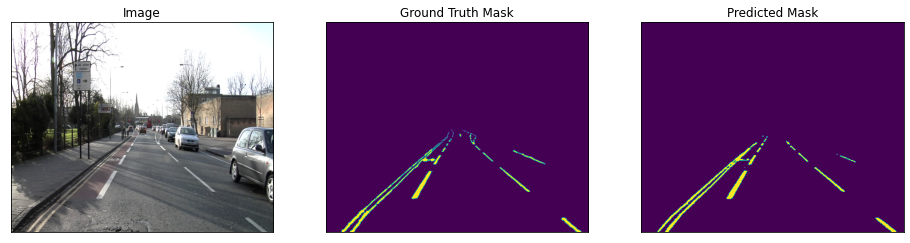

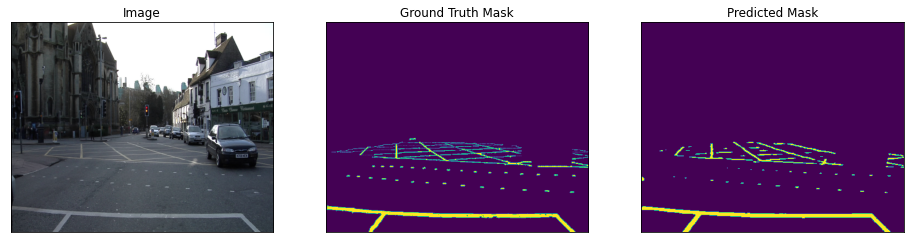

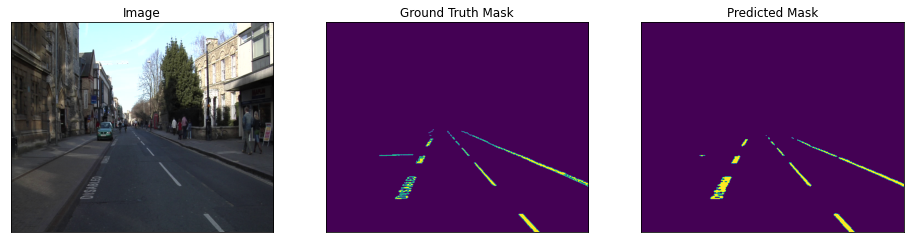

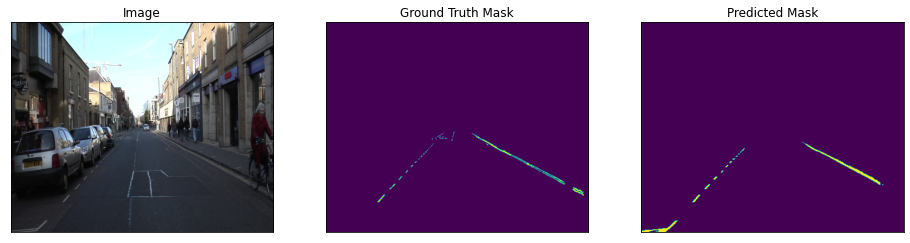

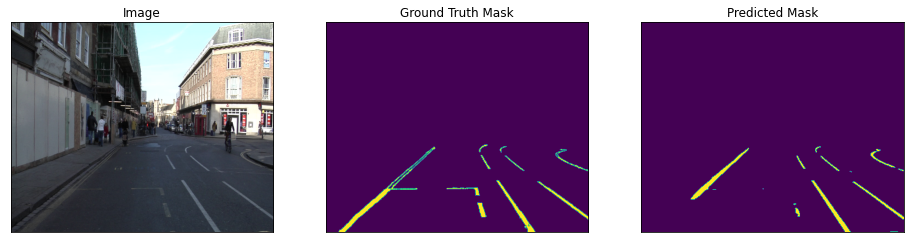

In [ ]:
for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )